# Exploratary Data Analysis (EDA)
Main goals for this EDA are:

- **Handling Missing Values:** Identify and address missing data to ensure a complete and accurate dataset.
- **Feature Selection:** Conduct a preliminary assessment to determine the most relevant features for analysis.
- **Problem Framing:** Clearly define and understand the problem to guide the analysis direction.
- **Pattern Discovery:** Uncover trends, patterns, and distributions within the data to gain initial insights.
- **Hypothesis Formulation:** Develop hypotheses based on observed data patterns to guide further analysis.
- **Assumption Checking:** Validate assumptions that are critical to the analysis and modeling process.
- **Outlier Detection:** Detect and manage outliers to prevent them from skewing the analysis results.
- **Relationship Exploration:** Investigate correlations and relationships between different variables in the dataset.

In [1]:
# import libraries
import os
import sys
import matplotlib as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import skew

# import custom libraries
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)
from app.config import SCHEMA
from app.libs import data_utils, eda_tools
from app import build_features

In [2]:
# read data
atp_df = data_utils.read_data(parent_dir + '/data/raw/atp')
wta_df = data_utils.read_data(parent_dir + '/data/raw/wta')

{"time": "2024-07-19T11:02:36Z", "level": "INFO", "log": "Reading all files in tennis-predictor\\venv/data/raw/atp..."}
{"time": "2024-07-19T11:02:37Z", "level": "INFO", "log": "Shape of the dataset: (36363, 54)"}
{"time": "2024-07-19T11:02:38Z", "level": "INFO", "log": "Reading all files in tennis-predictor\\venv/data/raw/wta..."}
{"time": "2024-07-19T11:02:39Z", "level": "INFO", "log": "Shape of the dataset: (7328, 38)"}


In [3]:
atp_df.columns

Index(['ATP', 'Location', 'Tournament', 'Date', 'Series', 'Court', 'Surface',
       'Round', 'Best of', 'Winner', 'Loser', 'WRank', 'LRank', 'W1', 'L1',
       'W2', 'L2', 'W3', 'L3', 'W4', 'L4', 'W5', 'L5', 'Wsets', 'Lsets',
       'Comment', 'B365W', 'B365L', 'CBW', 'CBL', 'GBW', 'GBL', 'IWW', 'IWL',
       'SBW', 'SBL', 'B&WW', 'B&WL', 'EXW', 'EXL', 'PSW', 'PSL', 'WPts',
       'LPts', 'UBW', 'UBL', 'LBW', 'LBL', 'SJW', 'SJL', 'MaxW', 'MaxL',
       'AvgW', 'AvgL'],
      dtype='object')

In [4]:
wta_df.columns

Index(['wta', 'location', 'tournament', 'date', 'tier', 'court', 'surface',
       'round', 'best_of', 'winner', 'loser', 'wrank', 'lrank', 'wpts', 'lpts',
       'w1', 'l1', 'w2', 'l2', 'w3', 'l3', 'wsets', 'lsets', 'comment',
       'b365w', 'b365l', 'cbw', 'cbl', 'exw', 'exl', 'psw', 'psl', 'ubw',
       'ubl', 'lbw', 'lbl', 'sjw', 'sjl'],
      dtype='object')

### Select relevant columns and handle missing values

Relevant variables for this model are:
 - date    - match's date
 - winner  - player's name
 - loser   - player's name
 - wrank   - winner's ranking
 - lrank   - loser's ranking
 - b365w   - odd given for the winner by B365
 - b365l   - odd given for the loser by B365
 - surface - type of court

The following columns gives us the final score, which is not usefull for the outcome predictive model.
 -  w1 - 1st set winning score
 -  l1 - 1st set losing score
 -  w2 - 2nd set winning score
 -  l2 - 2nd set losing score
 -  w3 - 3rd set winning score   
 -  l3 - 3rd set winning score       

Details on the tournament were also disregarded.

Ordering the df by Date allows me to calculate the head-to-head (records between two individual players).

In [5]:
# Rename cols
atp_df.rename(columns=lambda x: x.lower(), inplace=True)

# Drop matches that aren't completed
atp_df = atp_df[atp_df['comment'] == "Completed"]

# Correct typos: Replace occurrences of '..' with '.0'
wta_df['b365l'] = wta_df['b365l'].apply(lambda x: str(x).replace('..', '.0') if isinstance(x, str) and '..' in x else x)

# Select relevant columns
atp_df = atp_df[SCHEMA['raw'].keys()]
wta_df = wta_df[SCHEMA['raw'].keys()]

# Format data according to data schemas toml file
atp_df = data_utils.format_data(atp_df, SCHEMA['raw'])
wta_df = data_utils.format_data(wta_df, SCHEMA['raw'])

# Concat datasets
df = pd.concat([atp_df, wta_df])
print('(rows, columns): ',df.shape,'\n')

eda_tools.check_missing_data(df)

# Drop rows with any missing values
all_matches = len(df)
df = df.dropna()
matches = len(df)
print(f'This way of dealing with missing values results in a lost of {all_matches-matches} events ({round((all_matches-matches)/all_matches*100,2)}%).\n\n')

# display data info
print(df.info())
df.head(3)

{"time": "2024-07-19T11:02:40Z", "level": "INFO", "log": "Data formatted according to the imported schema..."}
{"time": "2024-07-19T11:02:41Z", "level": "INFO", "log": "Data formatted according to the imported schema..."}
(rows, columns):  (42312, 8) 

Missing Data Percentage List
wrank - 0.08%
lrank - 0.24%
b365w - 6.4%
b365l - 6.37%
This way of dealing with missing values results in a lost of 2815 events (6.65%).


<class 'pandas.core.frame.DataFrame'>
Index: 39497 entries, 1371 to 7327
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     39497 non-null  datetime64[ns]
 1   winner   39497 non-null  string        
 2   loser    39497 non-null  string        
 3   wrank    39497 non-null  Int64         
 4   lrank    39497 non-null  Int64         
 5   b365w    39497 non-null  float64       
 6   b365l    39497 non-null  float64       
 7   surface  39497 non-null  string        
dtypes: Int64(2), dateti

,date,winner,loser,wrank,lrank,b365w,b365l,surface
1371,2002-06-10,Johansson T.,Pretzsch A.,7,133,1.100,6.500,Grass
1372,2002-06-10,Kafelnikov Y.,Bjorkman J.,6,56,1.444,2.625,Grass
1374,2002-06-10,Koubek S.,Moya C.,41,20,2.625,1.444,Grass


### Frame the problem
The mission of this project is to recommend bets where the accuracy level exceeds the level of accuracy calculated for each betting odd, shown in the plot below. This accuracy level is calculated based on the possible gains or losses, representing the percentage of correct predictions needed to break even or make a profit in the long run.

 ```python
gains > losses
(betting_odd - 1) * accuracy > -1 * (1 - accuracy)
accuracy > 1 / betting_odd
```

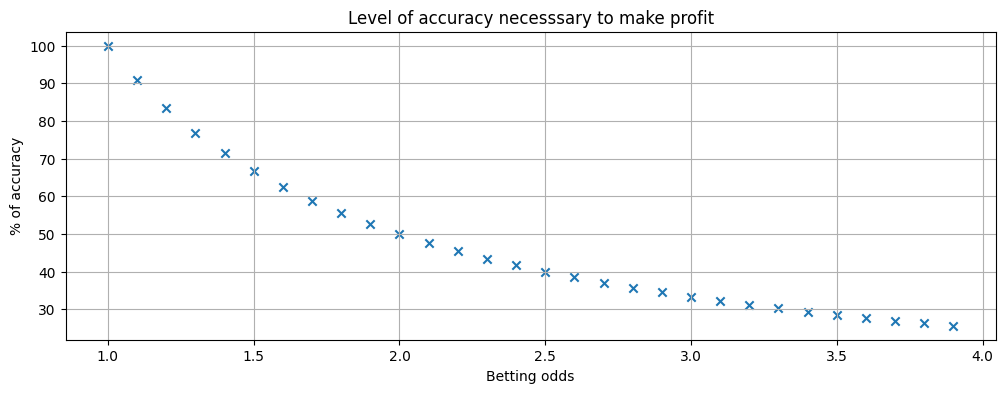

In [6]:
# plot between minimum value and 75th percentil of B365L
min_odd = df[['b365w','b365l']].min().min()
max_odd = df.describe().loc["75%", "b365l"]
odds = np.arange(min_odd, max_odd, 0.1)

# get accuracies
accuracies=[]
for betting_odd in odds:
    accuracy = 100 / betting_odd
    accuracies.append(accuracy)
plt.figure(figsize=(12,4))
plt.title('Level of accuracy necesssary to make profit')
plt.xlabel('Betting odds')
plt.ylabel('% of accuracy')
plt.scatter(odds, accuracies, marker='x')
plt.grid(True)
plt.show()

This recommendation system relies on the following condition:
- if prediction > 1 / odd_p1 then it will recommend betting on p1,
- if prediction < 1 / odd_p2 then it will recommend betting on p2,
- else it will not recommend (too risky).

<Axes: xlabel='winner_is_p1', ylabel='count'>

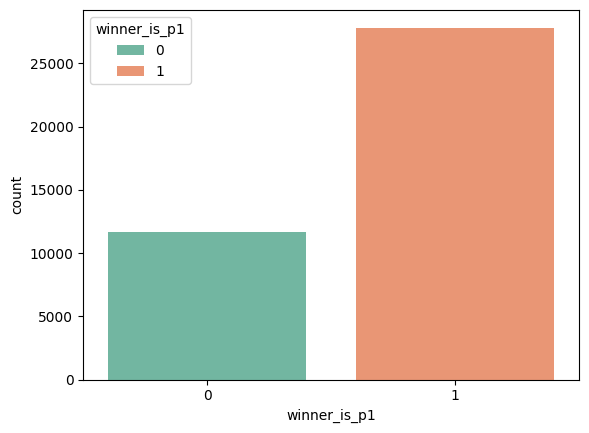

In [7]:
df['winner_is_p1'] = df.apply(build_features.winner_is_p1, axis=1)

# Plot target distribution
col='winner_is_p1'
sns.countplot(x=col, data=df, palette='Set2', hue=col)

### Discovering patterns on betting odds 

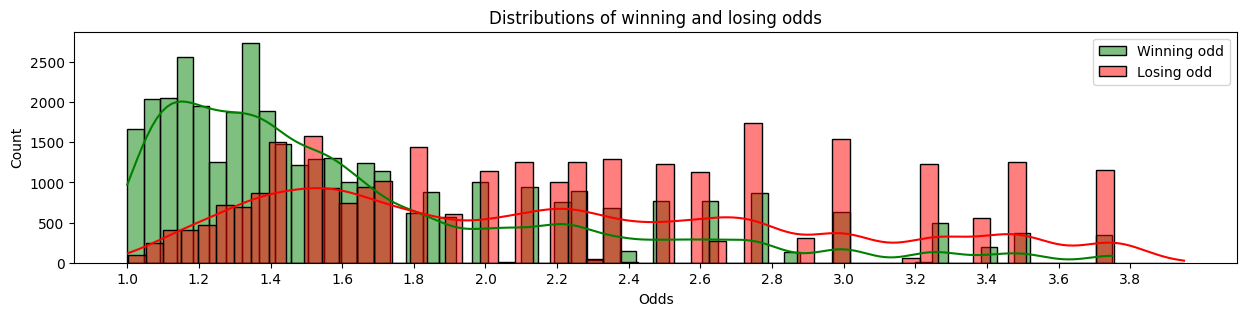

In [8]:
plt.figure(figsize=(15,3))

# use the 75th percentil of B365L to remove outliers
threshold = df.describe().loc["75%", "b365l"]

# create histogram for winning odds 
sns.histplot(df[df['b365w'] < threshold]['b365w'], bins=60, alpha=0.5, color='green', kde=True, label='Winning odd')

# create histogram for losing odds 
sns.histplot(df[df['b365l'] < threshold]['b365l'], bins=60, alpha=0.5, color='red', kde=True, label='Losing odd')

plt.xlabel('Odds')
plt.xticks(np.arange(1,4,0.2))
plt.title('Distributions of winning and losing odds')
plt.legend()
plt.show()

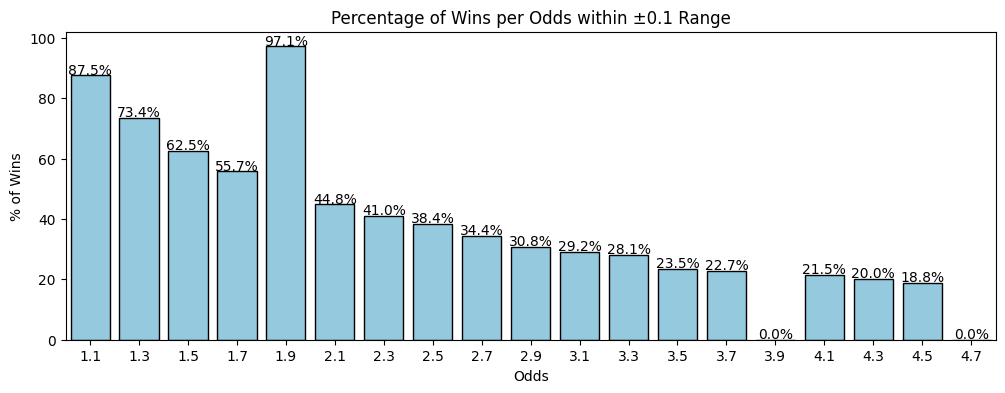

In [9]:
# Calculate the percentage of wins for each 0.05 interval
interval = 0.1
odds = np.arange(1.1 , 4.8 , 2 * interval)
win_percentages = []
total_odds = []

for i in odds:
    lower_bound, upper_bound = i - interval, i + interval
    wins_in_range = df[(df['b365w'] >= lower_bound) & (df['b365w'] < upper_bound)].shape[0]
    total_in_range = df[(df['b365w'] >= lower_bound) & (df['b365w'] < upper_bound) | (df['b365l'] >= lower_bound) & (df['b365l'] < upper_bound)].shape[0]
    win_percentages.append(wins_in_range / total_in_range * 100)
    total_odds.append(total_in_range)
    
plt.figure(figsize=(12,4))
sns.barplot(x=np.round(odds, 2), y=win_percentages, color='skyblue', edgecolor='black', dodge=False)
plt.xlabel('Odds')
plt.ylabel('% of Wins')
plt.title('Percentage of Wins per Odds within ±0.1 Range')
# Adding labeled values on top of each bar
for i in range(len(odds)):
    plt.text(i, np.round(win_percentages, 1)[i] + 0.5, str(np.round(win_percentages, 1)[i]) + '%', ha='center')
plt.show()

There's almost only wins between odds 1.8 and 2.0 because when both players have the same odd, those odds range from 1.8 to 2.0, as seen in the table below.

In [10]:
print('Equal Odds:')
df[df['b365w'] == df['b365l']][['b365w','b365l']].drop_duplicates()

Equal Odds:


,b365w,b365l
1732,1.833,1.833
3617,1.830,1.830
4493,1.909,1.909
15156,1.900,1.900


### Building features

 - <b>Rankings and Odds</b> - Both can be a valuable features but they have to be associated to the respective player (not the winner/loser.)
 - <b>Surface</b> - Since it is a categorical feature with no inherent ordering, One-Hot Encoding was used to represent each surface as a binary feature.
 - <b>Head-to-Head</b> - Records between two individual players.
 - <b>Number of consecutive wins and losses</b>
 - <b>Days since last win</b>

In [11]:
# save features list for analysis
features = []

# Ensure df is in chronological order
df = df.sort_values(by="date")

# Add match_id column
df['match_id'] = df.index

# Add rankings
df, features = build_features.add_ranks(df, features)

# Add the difference and ratio between players
df, features = build_features.add_rank_dif(df, features)
df, features = build_features.add_rank_ratio(df, features)

# Add player's odds
df['odd_p1'] = df.apply(lambda row: row['b365w'] if row['b365w'] < row['b365l'] else row['b365l'], axis=1)
df['odd_p2'] = df.apply(lambda row: row['b365w'] if row['b365w'] > row['b365l'] else row['b365l'], axis=1)

# Add the difference and ratio between players
df, features = build_features.add_odd_dif(df, features)
df, features = build_features.add_odd_ratio(df, features)

# Add a binary column for each surface
df, features = build_features.OHE_surface(df, features)  

# Add player's head-to-head
df, features = build_features.add_h2h(df, features)  

# Add consecutive wins or losses
df, features = build_features.add_consecutive_wins_and_losses(df, features)

# Add combined consecutive results (consecutive_wins_p1 - consecutive_wins_p2 - consecutive_losses_p1 + consecutive_losses_p2)
df, features = build_features.add_consecutive_results(df, features)

# Add ranking's evolution for each player
df, features = build_features.add_rank_evolution(df, features)

# Add combined rankings and rankings evolution (- rank_p1 + rank_p2 + rank_evol_p1 - rank_evol_p2)
df, features = build_features.add_rank_combined(df, features) 

# Add players' records (total wins - total losses)
df, features = build_features.add_records(df, features)


{"time": "2024-07-19T11:02:45Z", "level": "INFO", "log": "Adding player's rankings..."}
{"time": "2024-07-19T11:02:47Z", "level": "INFO", "log": " -> Added player's rankings. (1.958319)"}
{"time": "2024-07-19T11:02:48Z", "level": "INFO", "log": "Adding ranking's differences..."}
{"time": "2024-07-19T11:02:49Z", "level": "INFO", "log": " -> Added ranking's differences. (1.004781)"}
{"time": "2024-07-19T11:02:50Z", "level": "INFO", "log": "Adding ranking's ratio..."}
{"time": "2024-07-19T11:02:51Z", "level": "INFO", "log": " -> Added ranking's ratio. (1.001071)"}
{"time": "2024-07-19T11:02:53Z", "level": "INFO", "log": "Adding odd's differences..."}
{"time": "2024-07-19T11:02:54Z", "level": "INFO", "log": " -> Added odd's differences. (1.003991)"}
{"time": "2024-07-19T11:02:55Z", "level": "INFO", "log": "Adding odd's ratio..."}
{"time": "2024-07-19T11:02:56Z", "level": "INFO", "log": " -> Added odd's ratio. (1.001578)"}
{"time": "2024-07-19T11:02:57Z", "level": "INFO", "log": "One-hot-en

In [12]:
# save data
df.to_csv(parent_dir + '/data/interim/features.csv')

In [13]:
df = data_utils.read_data(parent_dir + '/data/interim/')

{"time": "2024-07-19T11:05:22Z", "level": "INFO", "log": "Reading all files in tennis-predictor\\venv/data/interim/..."}
{"time": "2024-07-19T11:05:23Z", "level": "INFO", "log": "Shape of the dataset: (39497, 32)"}


In [14]:
features = SCHEMA['features'].keys()
print(features)
eda_tools.check_missing_data(df[features])

dict_keys(['rank_p1', 'rank_p2', 'rank_diff', 'rank_ratio', 'odd_diff', 'odd_ratio', 'surface_Clay', 'surface_Hard', 'surface_Grass', 'h2h', 'consecutive_wins_p1', 'consecutive_wins_p2', 'consecutive_losses_p1', 'consecutive_losses_p2', 'consecutive_results', 'rank_evol_p1', 'rank_evol_p2', 'record_p1', 'record_p2', 'rank_combined'])
No missing values.


### Discovering patterns on features

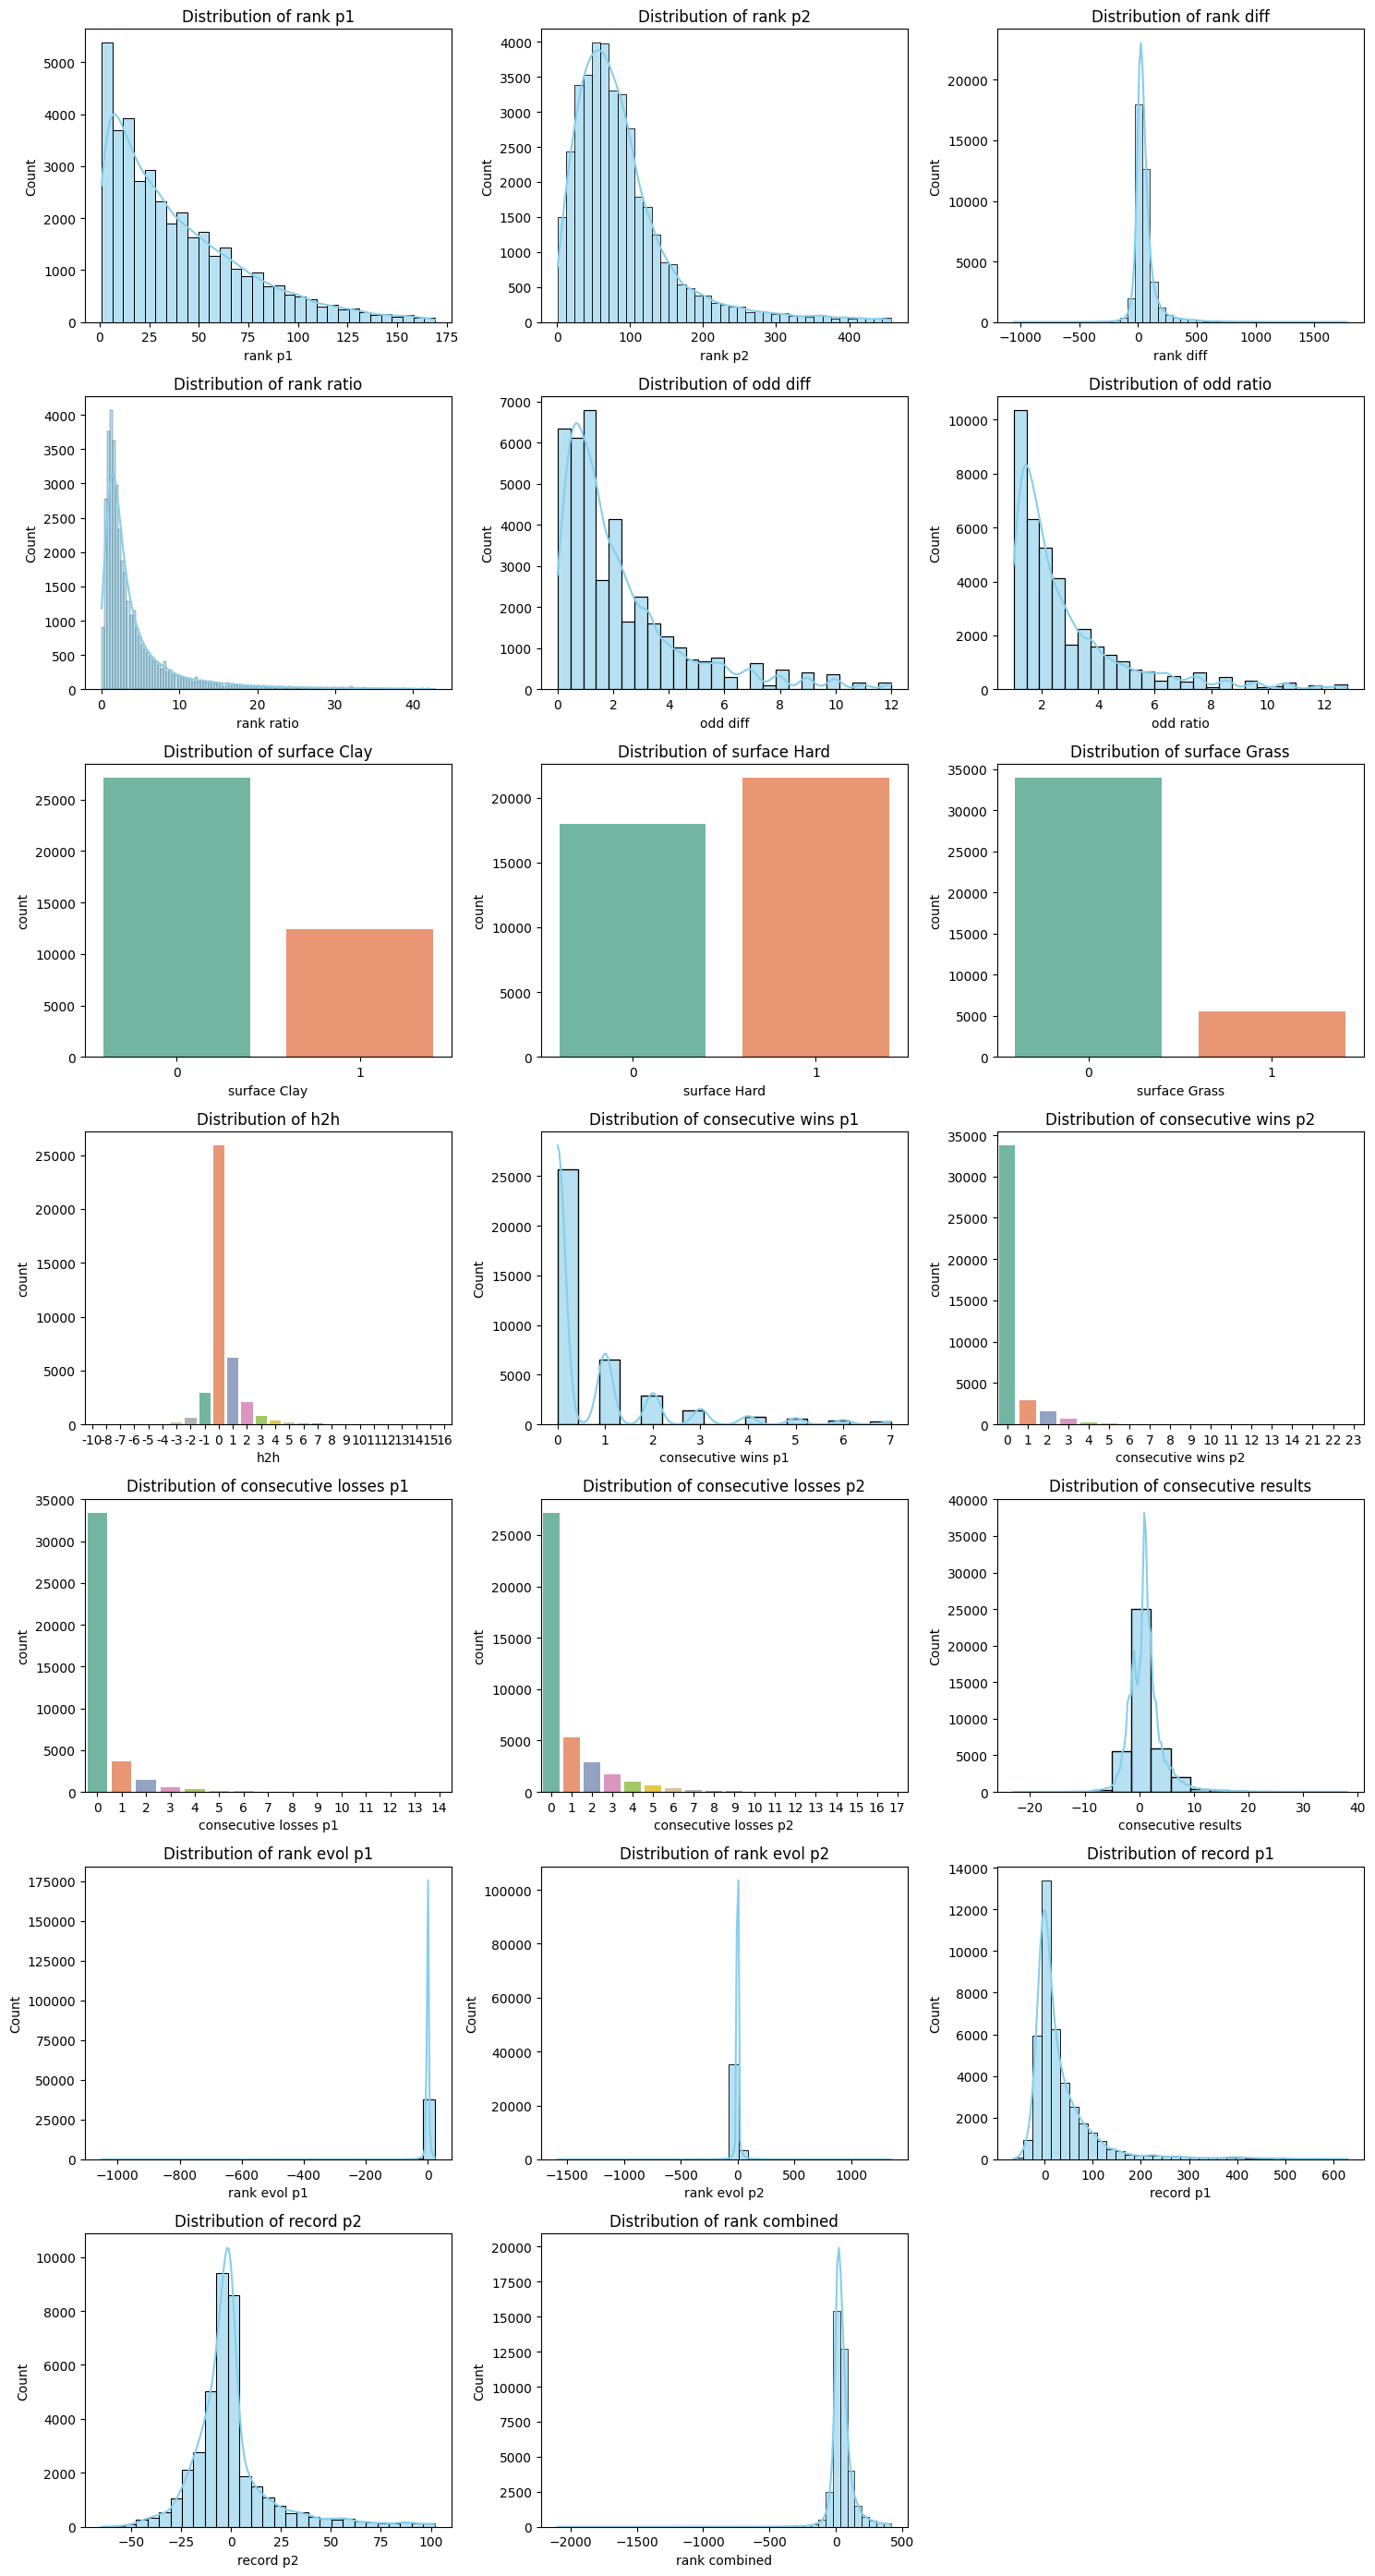

In [15]:
eda_tools.visualize_pd_series(df, features, skew_threshold=4, percentile_threshold=98)

### Outliers detection

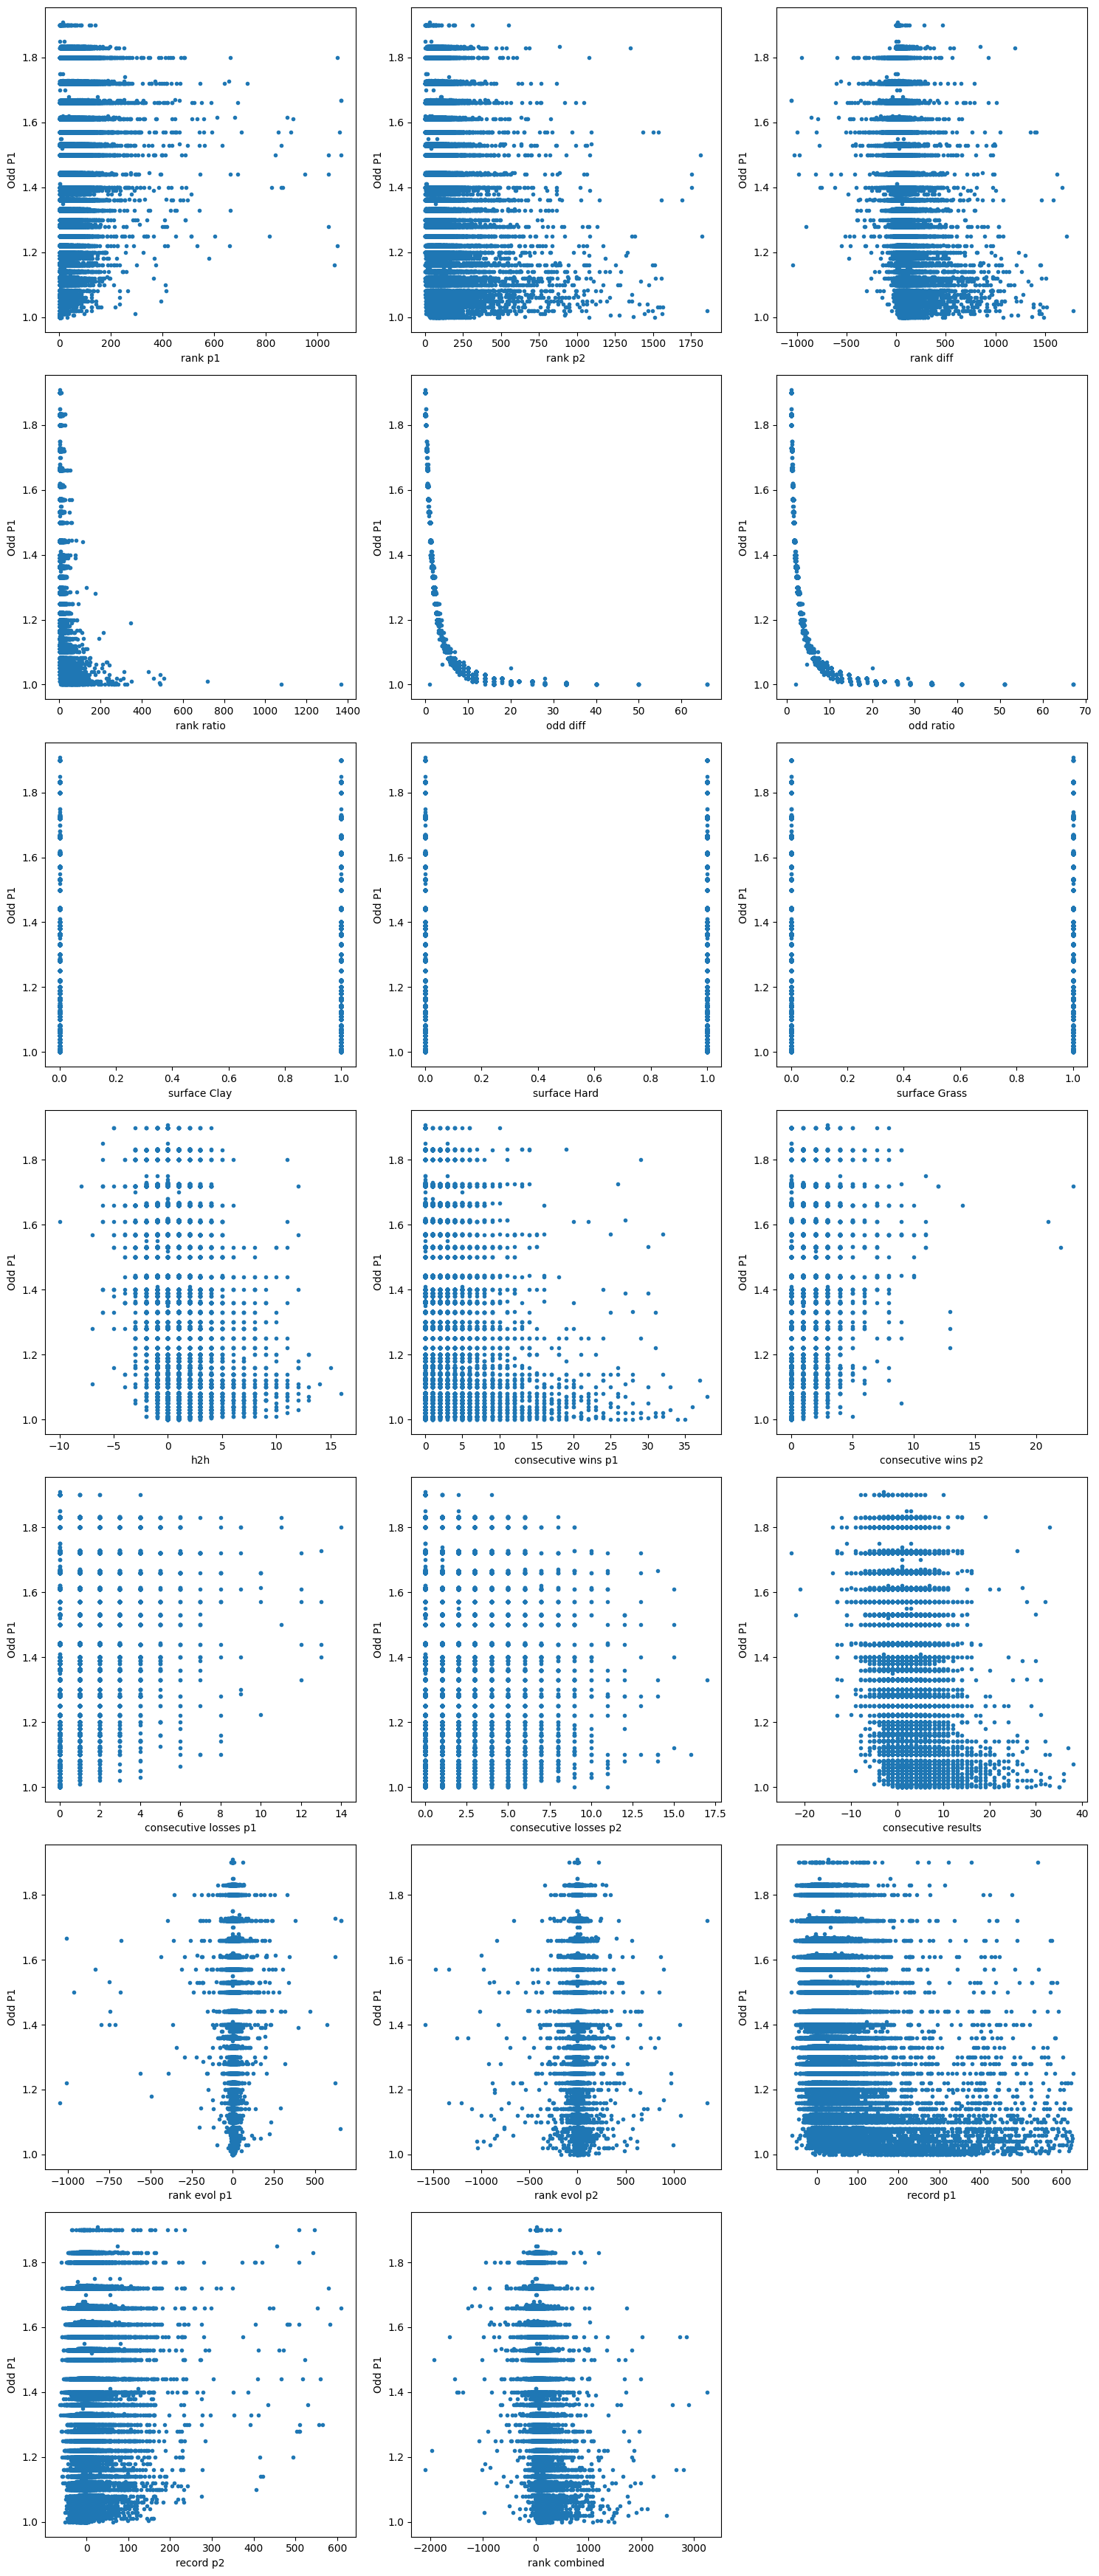

In [16]:
# Scatter plot for target with each feature
num_features = len(features)
cols = 3  # Number of columns for subplots
rows = (num_features + cols - 1) // cols  # Calculate rows needed

fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 5))
axs = axs.flatten()
y = df['odd_p1']

for i, col in enumerate(features):
    axs[i].scatter(df[col], y, marker='.')
    axs[i].set_xlabel(col.replace('_', ' '))
    axs[i].set_ylabel('Odd P1')

# Remove any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

By looking into the relation between player's 1 odd with each feature we can find some unexpected points that we'll considered as outliers. These points are under the following conditions:
 - odd_p1 < 1.35 and rank_p1 > 1000
 - odd_p1 < 1.35 and rank_diff < -700
 - odd_p1 > 1.6 and rank_diff > 700
 - odd_p1 < 1.1 and odd_diff < 5
 - odd_p1 < 1.1 and odd_ratio < 5
 - odd_p1 > 1.5 and consecutive_results > 20
 - odd_p1 < 1.3 and consecutive_results < -10
 - rank_evol_p1 < -500 
 - rank_evol_p1 > 500 
 - rank_evol_p2 < -500 
 - rank_evol_p2 > 500 

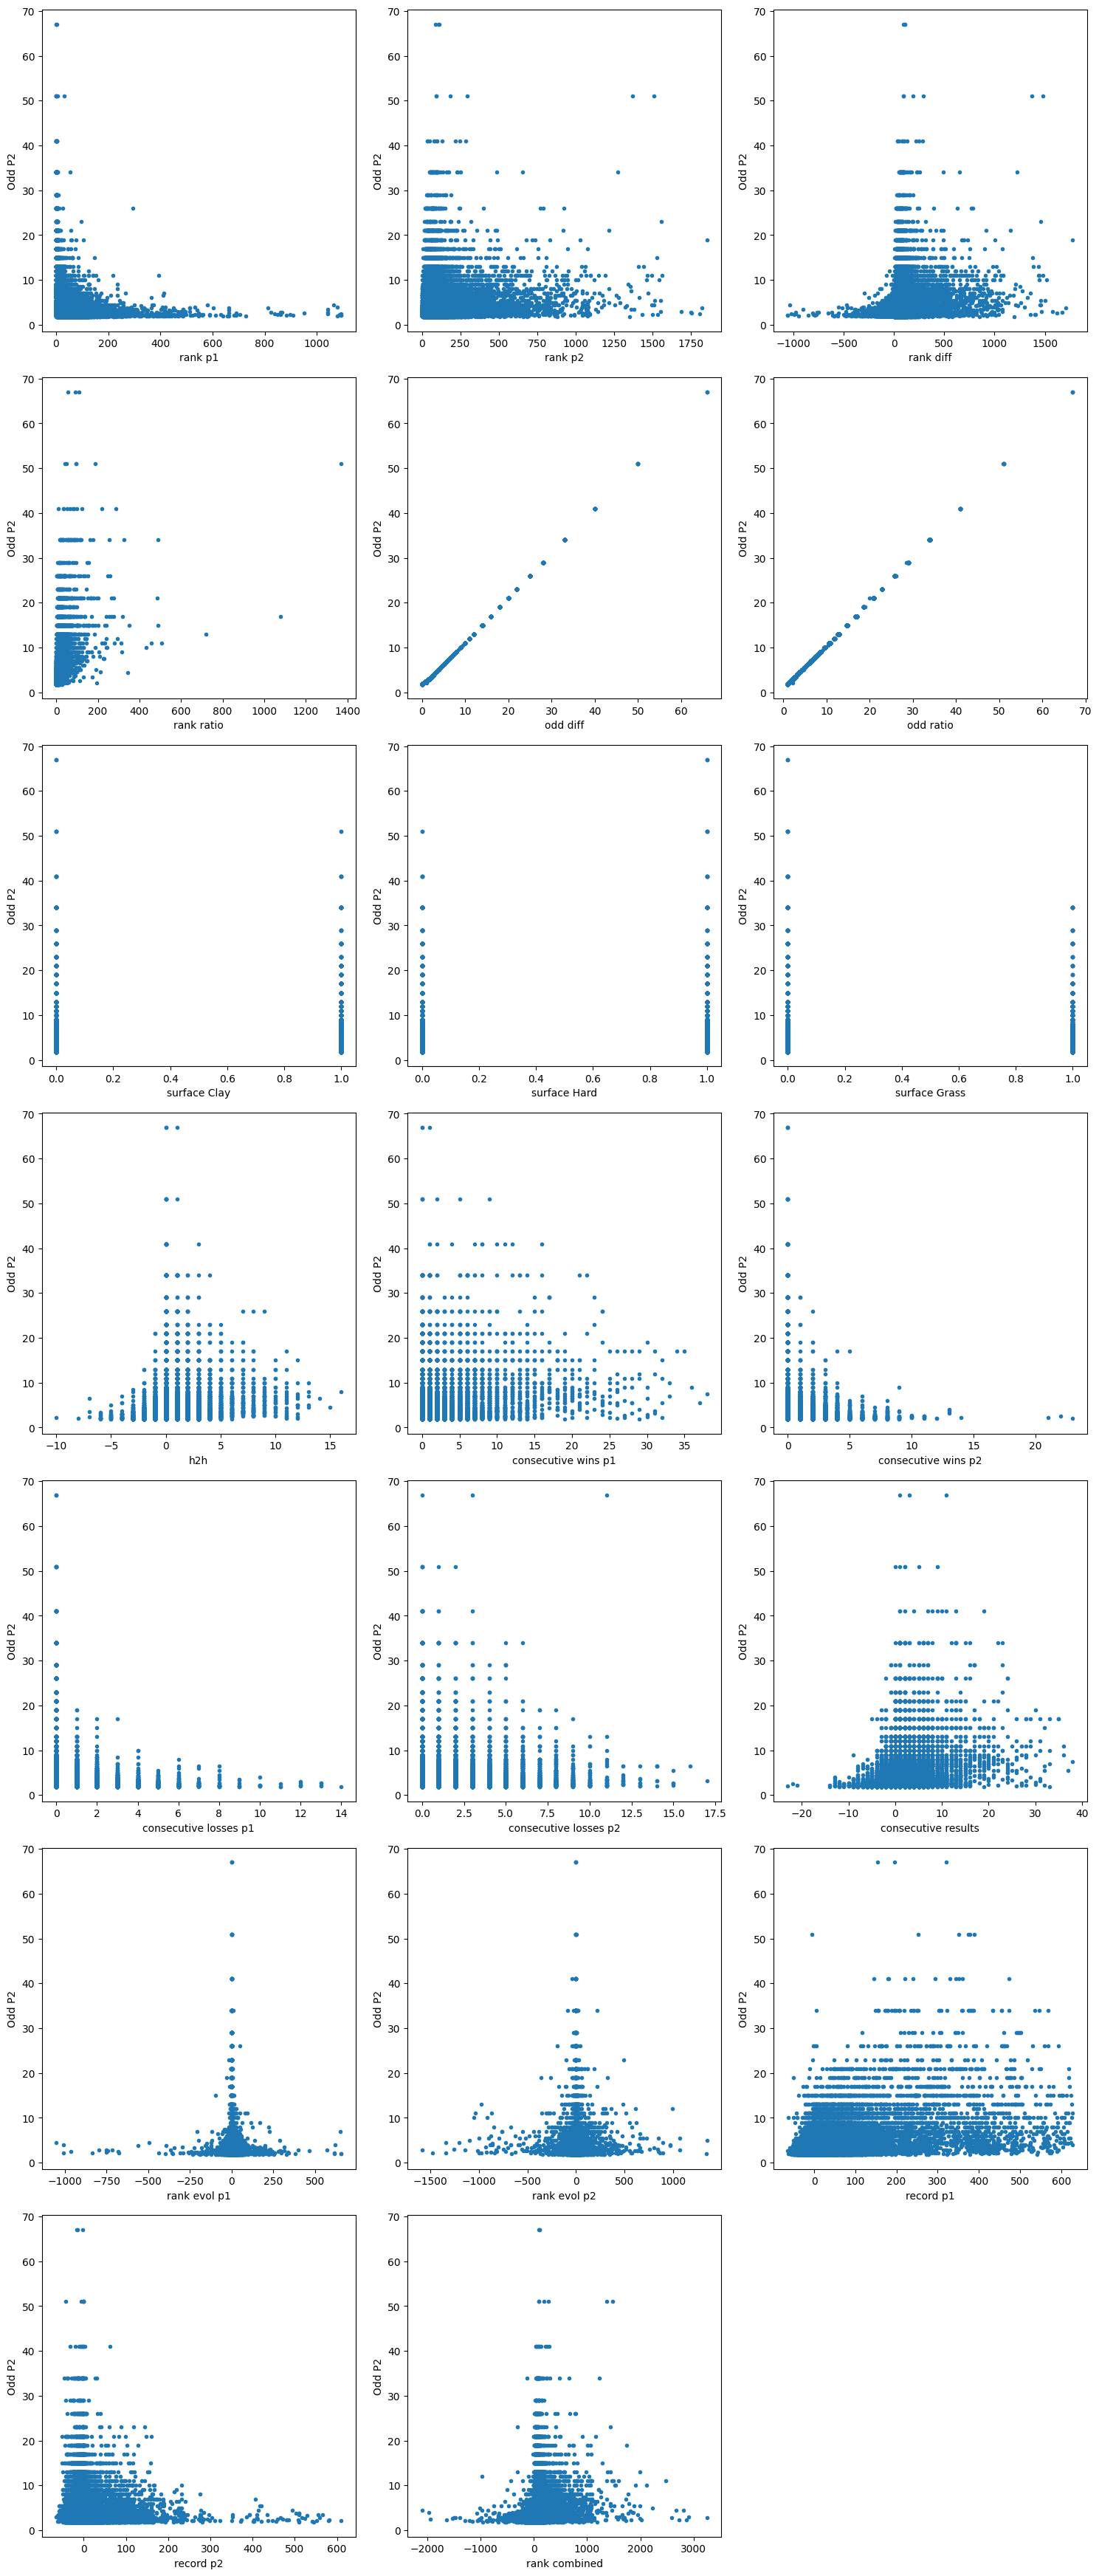

In [17]:
# Scatter plot for target with each feature
num_features = len(features)
cols = 3  # Number of columns for subplots
rows = (num_features + cols - 1) // cols  # Calculate rows needed

fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 5))
axs = axs.flatten()
y = df['odd_p2']

for i, col in enumerate(features):
    axs[i].scatter(df[col], y, marker='.')
    axs[i].set_xlabel(col.replace('_', ' '))
    axs[i].set_ylabel('Odd P2')

# Remove any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

By looking into the relation between player's 2 odd with each feature we can find some unexpected points that we'll considered as outliers. These points are under the following conditions:
 - odd_p2 > 20 and rank_p1 > 200

### Outliers removal

In [18]:
print('No. of events including outliers:', len(df))

# Define the conditions
conditions = [
    (df['odd_p1'] < 1.35) & (df['rank_p1'] > 1000),
    (df['odd_p1'] < 1.35) & (df['rank_diff'] < -700),
    (df['odd_p1'] > 1.6) & (df['rank_diff'] > 700),
    (df['odd_p1'] < 1.1) & (df['odd_diff'] < 5),
    (df['odd_p1'] < 1.1) & (df['odd_ratio'] < 5),
    (df['odd_p1'] > 1.5) & (df['consecutive_results'] > 20),
    (df['odd_p1'] < 1.3) & (df['consecutive_results'] < -10),
    (df['rank_evol_p1'] < -500),
    (df['rank_evol_p1'] > 500),
    (df['rank_evol_p2'] < -500),
    (df['rank_evol_p2'] > 500),
    (df['odd_p2'] > 20) & (df['rank_p1'] > 200),
]

# Combine conditions with logical OR
outliers = conditions[0]
for condition in conditions[1:]:
    outliers |= condition

# Filter out the outliers
df_filtered = df[~outliers]

print('No. of events without outliers:', len(df_filtered))
print('Dropped', round(100* (len(df) - len(df_filtered)) / len(df) , 2),'%')

No. of events including outliers: 39497
No. of events without outliers: 39364
Dropped 0.34 %


In [19]:
# save data
df_filtered.to_csv(parent_dir + '/data/processed/features.csv')

## Features Correlation

Column pairs with correlation above 0.7
                 level_0              level_1     0
23               rank_p2            rank_diff  True
40               rank_p2        rank_combined  True
43             rank_diff              rank_p2  True
61             rank_diff        rank_combined  True
89              odd_diff            odd_ratio  True
109            odd_ratio             odd_diff  True
133         surface_Clay         surface_Hard  True
153         surface_Hard         surface_Clay  True
224  consecutive_wins_p1  consecutive_results  True
304  consecutive_results  consecutive_wins_p1  True
400        rank_combined              rank_p2  True
401        rank_combined            rank_diff  True


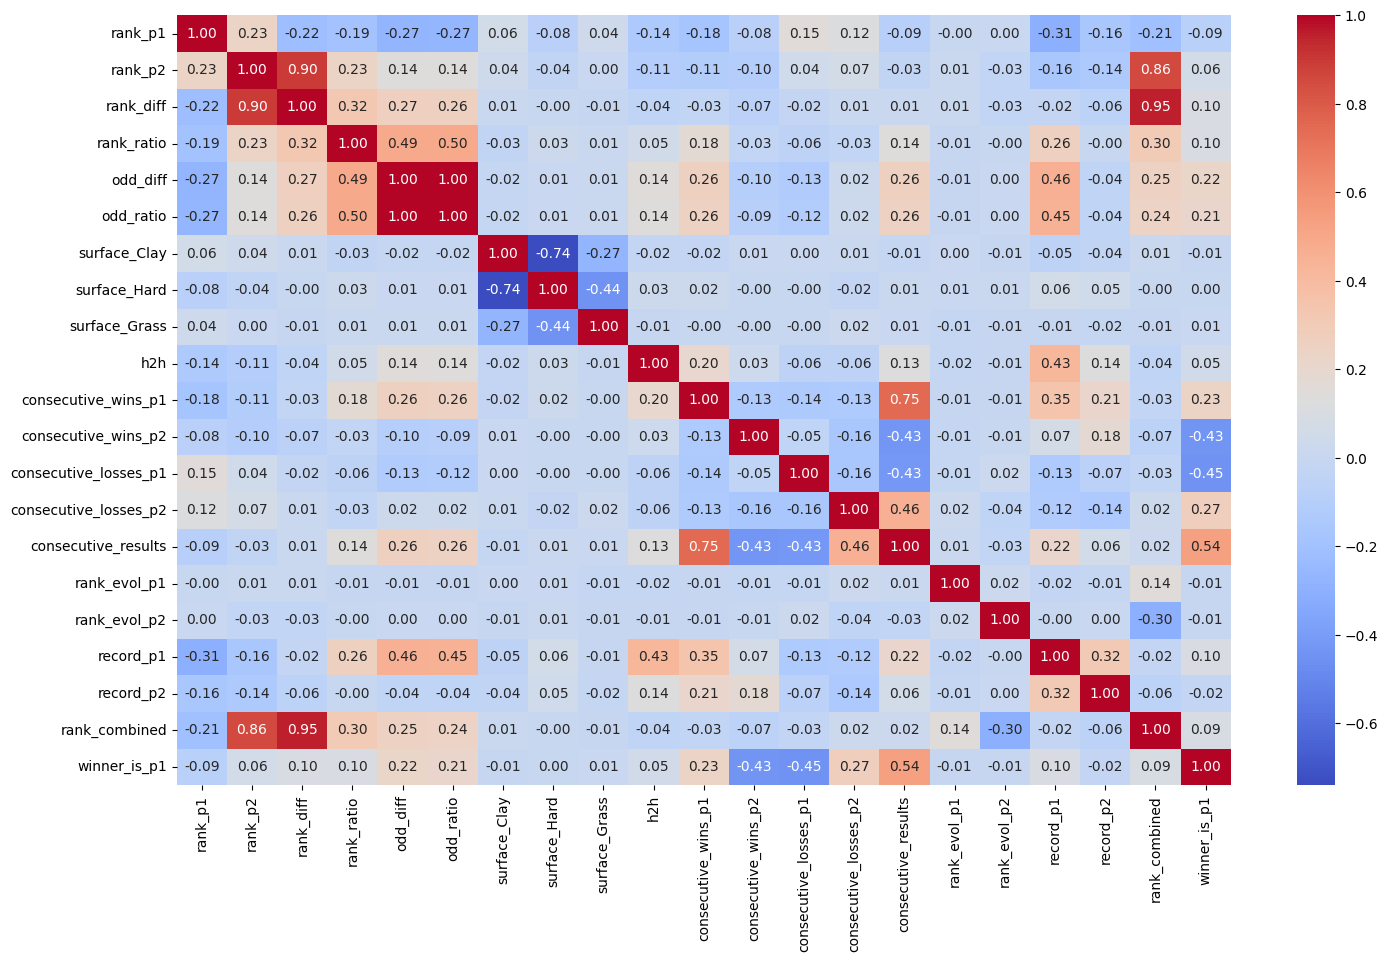

In [20]:
cols = list(features)
cols.append('winner_is_p1')
correlation_matrix = df_filtered[cols].corr()
threshold = 0.7

# Display column names where correlation exceeds the threshold
high_correlation_columns = (correlation_matrix.abs() > threshold) & (correlation_matrix != 1)
correlated_columns = high_correlation_columns.unstack().reset_index()
correlated_columns = correlated_columns[correlated_columns[0]].rename_axis(None, axis=1)
if correlated_columns.empty:
    print('There are no correlated features.')
else:
    print("Column pairs with correlation above", threshold)
    print(correlated_columns)

# Config figure size
plt.figure(figsize=(17,10))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Display the plot
plt.show()

From this visualization, we find that consecutive_results are a good indicator on wheter p1 is the winner. Although other features don't seem to have a big impact on the target, it may be due to it's skewness, as we will explore on 2.0-feature-engineering notebook.